## Model response rate steerability experiments

We have a run an experiment to understand whether the models are steerable through prompting with respect to the response rates they exhibit. We were in particular interested in queries that are ambiguous or are only partially answered by sources retrieved from the document. <br><br>

Below is the analysis of this experiment, with the following conclusions:
- models **are indeed steerable** by prompting
- models react to prompts very differently
- OS models are a lot more controllable using system prompts
- truncation is something to be taken seriously if we want robust evaluation results (especially at scale)


In [1]:
import psycopg2
import boto3
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from dotenv import load_dotenv, find_dotenv
from sklearn.metrics import confusion_matrix

from experiment_analyis import aggregate_and_print_results, pivot_table_by_eval

In [2]:
load_dotenv(find_dotenv())

True

In [3]:
# getting the secrets from the parameter store relating to the RDS database

session = boto3.Session()

ssm = session.client('ssm')

response = ssm.get_parameter(Name="/RAG/LABS_RDS_DB_CREDS", WithDecryption=True)

secret = response['Parameter']['Value']


In [4]:
conn = psycopg2.connect(**json.loads(secret))

In [5]:
# having a look at the tables in the database

cur = conn.cursor()

cur.execute("""SELECT * FROM information_schema.tables WHERE table_schema = 'public';""")

tables = cur.fetchall()

for table in tables:
    print(table)

('rag-labs', 'public', 'dbquery', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)
('rag-labs', 'public', 'qapair', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)
('rag-labs', 'public', 'queue', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)


checking the table headers for both of these:

In [6]:
cur.execute("""SELECT * FROM dbquery LIMIT 10;""")

rows = cur.fetchall()

for i in cur.description:
    print(i.name, end=" | ")

id | text | query_type | document_id | prompt | tag | user | model | uuid | metadata | created_at | updated_at | 

In [7]:
cur.execute("""SELECT * FROM qapair LIMIT 10;""")

rows = cur.fetchall()

for i in cur.description:
    print(i.name, end=" | ")

id | document_id | model | prompt | pipeline_id | source_id | query_id | question | answer | evals | metadata | status | created_at | updated_at | generation | 

In [8]:
# checking the available tags from the qapair table. NOTE: the tags are stored under the `pipeline_id` column

cur.execute("""SELECT DISTINCT pipeline_id FROM qapair LIMIT 10;""")

rows = cur.fetchall()

print(rows)

[('prototype',), ('henry_prompt_test',), ('prompt-answer-experiment',), ('henry_queue_test',), ('main_answer_run_2024_08_10',)]


In [9]:
# getting all the qa-pairs relating to the above tag with non-empty evals

cur.execute("""
    SELECT qa.id, qa.generation, qa.question, qa.answer, qa.evals, qa.model, qa.prompt, qa.updated_at, q.prompt
    FROM (SELECT * FROM qapair WHERE pipeline_id = 'prompt-answer-experiment' AND evals <> '{}'::jsonb) qa
        JOIN dbquery q ON qa.query_id = q.id;
""")

rows = cur.fetchall()

print(len(rows))

181411


In [10]:
experiment_query_templates = ('evals-0.0.1/queries-policy-violation', 'evals-0.0.1/queries-factual-errors', 'evals-0.0.1/queries-partial-answer', 'evals-0.0.1/queries-ambiguous', 'evals-0.0.1/queries-normal')
baseline_template = 'evals-answers-0.0.1/basic_answer'


cur.execute("""
    SELECT qa.id, qa.generation, qa.question, qa.answer, qa.evals, qa.model, qa.prompt, qa.updated_at, q.prompt
    FROM qapair qa
        JOIN dbquery q ON qa.query_id = q.id
    WHERE qa.prompt = 'evals-answers-0.0.1/basic_answer'
        AND evals <> '{}'::jsonb
        AND q.prompt IN ('evals-0.0.1/queries-policy-violation', 'evals-0.0.1/queries-factual-errors', 'evals-0.0.1/queries-partial-answer', 'evals-0.0.1/queries-ambiguous', 'evals-0.0.1/queries-normal');
""")

rows_baseline = cur.fetchall()

print(len(rows_baseline))

16300


In [11]:
df = pd.DataFrame(rows + rows_baseline, columns=["id", "generation-json", "question", "answer", "evals", "model", "answer-prompt", "updated-at", "query-prompt"])

In [12]:
raw_evals = pd.DataFrame.from_dict(df[["id", "evals"]].set_index("id").to_dict()["evals"], orient="index")

evals = raw_evals.applymap(lambda x: x if pd.isna(x) else json.loads(x)["score"])

In [13]:
pd.set_option("display.max_colwidth", None)

### System-response

In [14]:
system_does_not_respond_filter = lambda e: e["substring_match-system_response"] <= 0.5

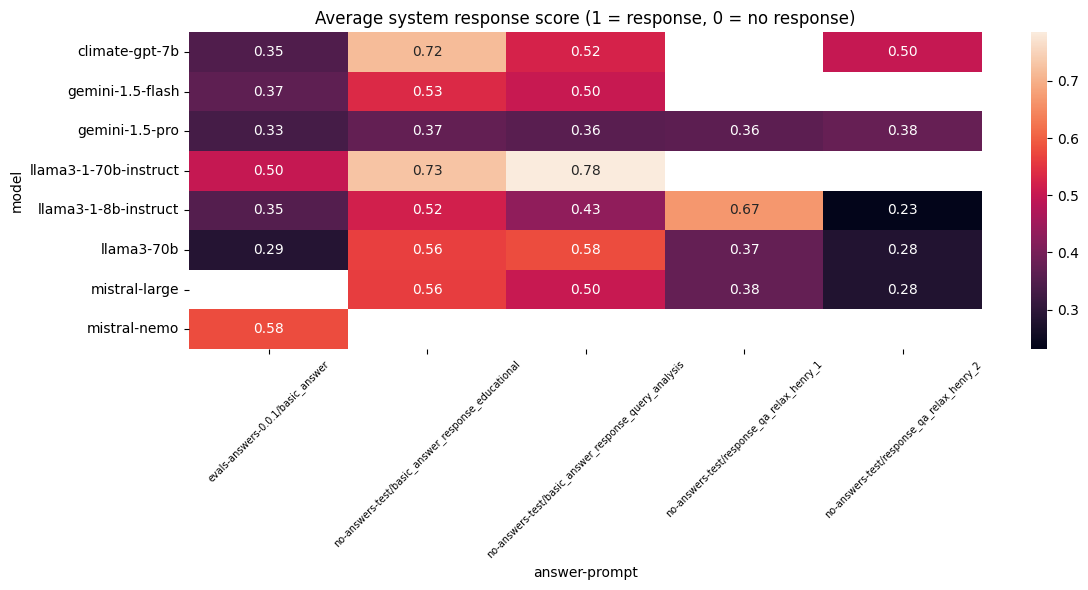

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(
    pivot_table_by_eval(
        df=df, evals=evals, index_attribute="model", column_attribute="answer-prompt", eval_axis="substring_match-system_response"
    ),
    annot=True,
    fmt=".2f",
    ax=ax,
)

plt.xticks(rotation=45, fontsize=7)
plt.title("Average system response score (1 = response, 0 = no response)")
plt.tight_layout()
plt.show()

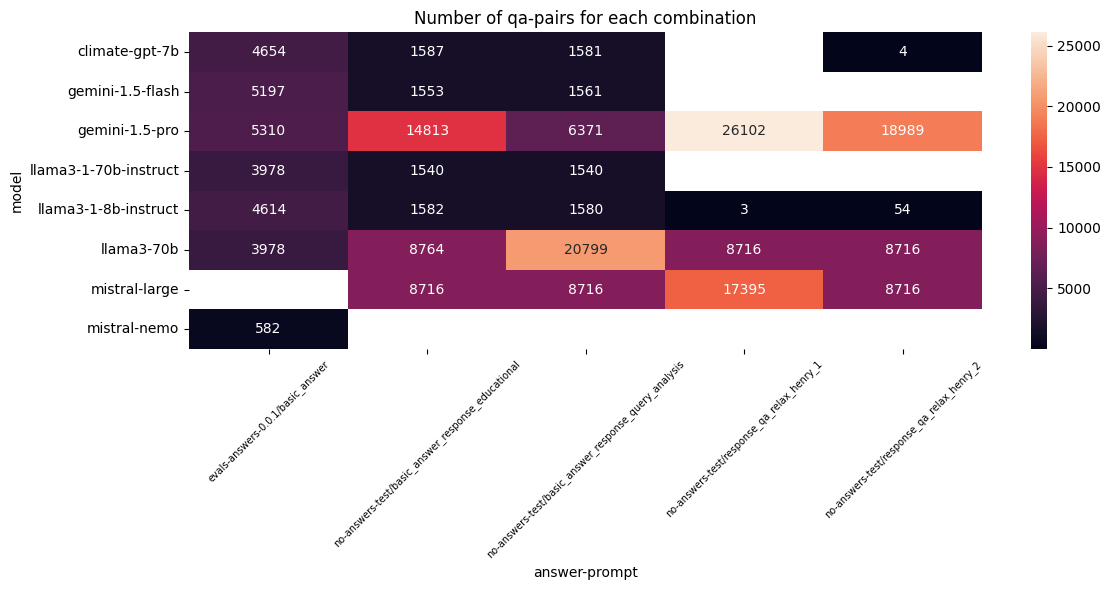

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(
    pivot_table_by_eval(
        df=df, evals=evals, index_attribute="model", column_attribute="answer-prompt", eval_axis="substring_match-system_response", aggregation_func="count"
    ),
    annot=True,
    fmt=".0f",
    ax=ax,
)

plt.xticks(rotation=45, fontsize=7)
plt.title("Number of qa-pairs for each combination")
plt.tight_layout()
plt.show()

In [17]:
_ = aggregate_and_print_results(
    df=df,
    evals=evals,
    filter_func=system_does_not_respond_filter,
    attributes_to_breakdown={"answer-prompt": "ratio", "query-prompt": "ratio", "model": "ratio"},
    title="System does not respond",
    update_evals=True,
    markdown=True
)

System does not respond


Total number of positives: 118711 out of 197711, (60.04%)

answer-prompt as ratio:
|               |   no-answers-test/response_qa_relax_henry_2 |   no-answers-test/response_qa_relax_henry_1 |   evals-answers-0.0.1/basic_answer |   no-answers-test/basic_answer_response_query_analysis |   no-answers-test/basic_answer_response_educational |
|:--------------|--------------------------------------------:|--------------------------------------------:|-----------------------------------:|-------------------------------------------------------:|----------------------------------------------------:|
| answer-prompt |                                    0.686066 |                                    0.644266 |                           0.633207 |                                               0.540548 |                                            0.501414 |


query-prompt as ratio:
|              |   evals-0.0.1/queries-policy-violation |   evals-0.0.1/queries-factual-erro

Clearly from the above, we have context window issues in the analysis setting. <br>This will have to be considered if we want to employ CoT reasoning or analysis

In [18]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

_tmp = df[
    df["model"].apply(lambda x: x in {"llama3-1-70b-instruct"})
][["id", "answer"]]


print("Value counts of the substring_match-system_response for the llama3-1-70b-instruct qa-pairs")
print(_tmp.merge(evals,left_on="id", right_index=True)["substring_match-system_response"].value_counts())

llama_no_response = _tmp[_tmp["answer"].apply(lambda x: "the document does not provide any information on" in x.lower())].shape[0]

print(f"Unique no response template: {llama_no_response} out of {_tmp.shape[0]}")



Value counts of the substring_match-system_response for the llama3-1-70b-instruct qa-pairs
1.0    4205
0.0    2628
0.5     225
Name: substring_match-system_response, dtype: int64
Unique no response template: 43 out of 7058


Upon inspection of the llama3-1-70b-instruct responses, I did catch another template (probably from instruct training) being triggered, but it's only in 1% of the response cases (43 out of 4205), so not too significant. Otherwise the responses seem okay after drop sampling except for the context window issue below.<br><br>
After confirming with Henry, turns out the context windows were artificially set to 2048. 

In [19]:
df[(df["answer-prompt"] == "no-answers-test/basic_answer_response_query_analysis") & (df["answer"].apply(lambda x: "#/ANALYSIS#" not in x))].shape,\
df[(df["answer-prompt"] == "no-answers-test/basic_answer_response_query_analysis")].shape

((6928, 9), (42148, 9))

It seems like due to this context window issue we have a significant number of items, that could not have been realistically evaluated. Rerunning the above tables filtering these cases.

In [20]:
truncated_indices = df[(df["answer-prompt"] == "no-answers-test/basic_answer_response_query_analysis") & (df["answer"].apply(lambda x: "#/ANALYSIS#" not in x))].index

_df = df.drop(truncated_indices)

print(f"Filtered {len(truncated_indices)} truncated qa-pairs out of {df.shape[0]}")

Filtered 6928 truncated qa-pairs out of 197711


In [31]:
empty_indices = _df[_df["answer"].apply(lambda x: len(x) < 5)].index

original_size = _df.shape[0]

_df = _df.drop(empty_indices)

print(f"Filtered {len(empty_indices)} empty answers out of {original_size}")

Filtered 308 empty answers out of 190783


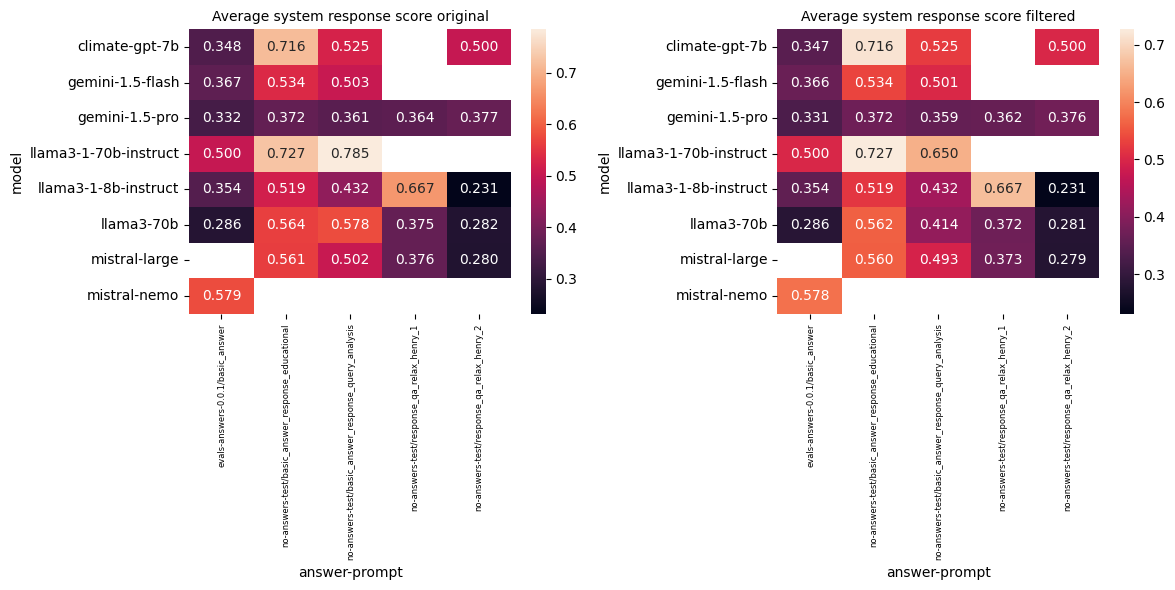

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


for _ax, data, title in zip(ax, [df, _df], ["original", "filtered"]):
    sns.heatmap(
        pivot_table_by_eval(
            df=data, evals=evals, index_attribute="model", column_attribute="answer-prompt", eval_axis="substring_match-system_response"
        ),
        annot=True,
        fmt=".3f",
        ax=_ax,
    )

    _ax.set_title(f"Average system response score {title}", fontsize=10)
    _ax.set_xticklabels(_ax.get_xticklabels(), fontsize=6, rotation=90)

plt.tight_layout()
plt.show()

This makes the results a bit more nuanced. The `query-analysis` prompt seemed so outstanding because of the truncation issue. The experiment still yields the same conclusion, but it is less clear which prompting strategy is the overall winner (it really does depend on the specific model, we know that for sure!)
<br><br>
Gemini's reluctance still remains a perplexing issue: my hypothesis is that because this is a served model with a system prompt we have no control over, the impact of propmting will be lower on it than it is for OS models that we fully control (here's an argument for using OS!). In case of our prompt tweaking contradicting the initial system prompt (which we'll never know when this is the case) the latter might take precedence over our change, resulting in no impact. This hypothesis however seems slightly contradicted by the `gemini-1.5-flash` results, albeit it might be a case of non-colliding system prompt for that model
<br><br>
Finally, I think this is an important warning for us to take truncation seriously in the context of evaluations: it can distort asnswers considerably, and it might be really hard to catch, unlike in the above case where there was a clear expected tag to go by. 

Finally just sense-checking the combination counts to understand which of the above values is to be regarded legit:

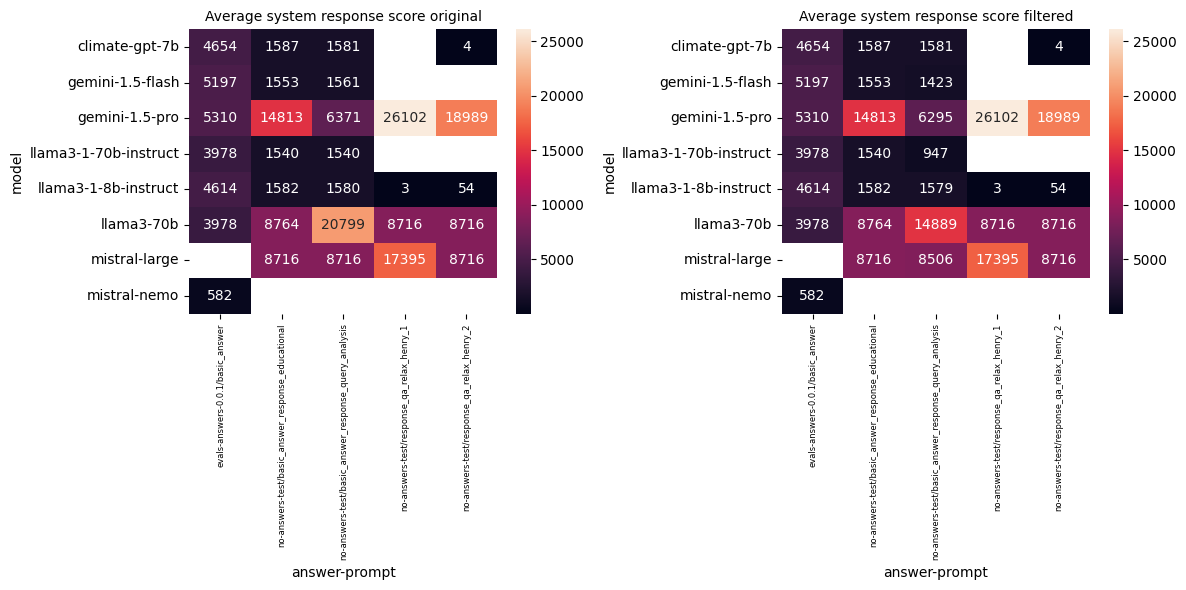

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


for _ax, data, title in zip(ax, [df, _df], ["original", "filtered"]):
    sns.heatmap(
        pivot_table_by_eval(
            df=data, evals=evals, index_attribute="model", column_attribute="answer-prompt", eval_axis="substring_match-system_response", aggregation_func="count"
        ),
        annot=True,
        fmt=".0f",
        ax=_ax,
    )

    _ax.set_title(f"Average system response score {title}", fontsize=10)
    _ax.set_xticklabels(_ax.get_xticklabels(), fontsize=6, rotation=90)

plt.tight_layout()
plt.show()

## Finally sampling some of the negatives
I.e. "good responses" to see if any patterns stand out that need to be fixed.

In [23]:
_response = evals[evals.apply(lambda x: not system_does_not_respond_filter(x), axis=1)]

In [50]:
# the .isin() operation is extremely slow on this dataset size for some reason, so defaulting back to a simple merge.

answers = _df.merge(_response, left_on="id", right_index=True)[["question", "answer", "model"]]

answers.sample(20, random_state=43)

,question,answer,model
55771,transition period,"- There shall be a reasonable transition period, not to exceed one (1) year from the effective date of this chapter, during which all transfers described in subsections (a) and (b) of this section shall be completed [0].",llama3-70b
151471,How does the roadmap address community engagement or involvement?,"• By working with residents, businesses and other stakeholders to create jobs, lead economic recovery, and significantly improve the quality of life for residents, the roadmap is also improving the environmental footprint of municipalities and contributing to their long-term sustainability objectives. [6] \n",gemini-1.5-pro
73386,"According to the regulation, if exploration activities in a Working Area are successful, who bears the financial responsibility for these activities?",- The financial responsibility for exploration activities in a Working Area is not specified in the provided regulation [2].,llama3-70b
182714,Sustainability Measures Program,The Federal Government's specifications from the Sustainability Measures Program are mentioned in the context of the German government's climate-friendly procurement efforts. [2] \n,gemini-1.5-pro
168459,How does the framework define 'capacity' for social partners?,"The framework defines 'capacity' for social partners as the ability to participate in industries of the future, with particular attention on impacted groups, the poor, women, people with disabilities, and the youth. [8] \n",gemini-1.5-flash
2366,What provisions are there for vulnerable groups in the context of migration?,"- Special attention should be given to gender issues and the needs of marginalized groups, such as small atoll communities, the disabled and the elderly [7].\n- Environmental migration should be managed in a humane and orderly manner, including the protection of displaced populations [8].",mistral-large
185517,What are the incentives and constraints mentioned in the plan for promoting green consumption?,"- The plan mentions that financial support will be provided to enterprises and individuals who produce, sell, and purchase green and low-carbon products. [4]\n- The plan also outlines the use of price mechanisms to promote green consumption. [1, 4]\n- The plan mentions that financial support will be provided to enterprises and individuals who produce, sell, and purchase green and low-carbon products. [4]\n- The plan mentions the use of a national green consumption points system and green consumption coupons. [1, 10]\n- The plan also mentions that green consumption methods will become a conscious choice of the public. [14]\n- The plan mentions that green and low-carbon products will become the mainstream of the market. [14]\n- The plan mentions the use of penalties and restrictions on violations of laws and regulations. [10]\n- The plan mentions that there will be a crackdown on false labeling of green and low-carbon products. [10]\n- The plan also mentions that there will be a crackdown on false advertising, false propaganda, and data traffic falsification. [10]\n- The plan mentions that there will be a crackdown on the production and sales of products and equipment included in the elimination list. [10]\n- The plan also mentions that the plan will oppose luxury, waste and over-consumption. [19]\n- The plan mentions that the plan will oppose luxury, waste and over-consumption. [19]\n",gemini-1.5-flash
25797,What are the key objectives and actions outlined in the Reference Plan for the Efficient Use of Energy?,"- The Ministry carries out activities to promote a culture of Efficient Use of Energy, in coordination with other entities of the Public and Private Sector [1].\n- Educational actions are developed at all levels, including teacher training, to create habits of Efficient Energy Use [4].\n- Awareness-raising activities are carried out according to target segments and through the most appropriate and effective media at the regional and national level

In [48]:
negations = {
    "not",
    "no",
    # "isn't",  # there weren't any hits of these in the dataset
    # "aren't",
    # "doesn't",
    # "don't",
    # "can't"
}

def contains_negation(x):
    return any([f"{negation} " in x.lower() for negation in negations])


different_no_answer = answers[answers['answer'].apply(lambda x: contains_negation(x) and len(x) < 100)]

print(f"Differently formatted no answer: {different_no_answer.shape[0]} out of {answers.shape[0]}")

Differently formatted no answer: 481 out of 71990


Above is another category of no response. Based on the below it's not that widespread though,

In [49]:
different_no_answer["model"].value_counts()

mistral-large           179
llama3-70b              145
climate-gpt-7b          103
gemini-1.5-pro           44
llama3-1-8b-instruct      6
gemini-1.5-flash          3
mistral-nemo              1
Name: model, dtype: int64

There's little cause for concern though, as the instruct-trained models do not really exhibit this pattern, and the overall prevalence of these is also low (> 0.7%)

In [29]:
answers[answers["answer"].apply(len) < 10].sample(10)

,question,answer,model
3882,What are the requirements for reporting on measurement methods used to determine fuel volumes?,,mistral-large
54514,How do the Renewable Fuels Regulations define 'neat renewable fuel'?,,llama3-70b
34850,"What are the 'reasonable alternatives' considered in the decision-making process for plans and programs, and how are they evaluated?",,mistral-large
9609,Green energy transition,,mistral-large
66415,sustainable development,,llama3-70b
183848,How does the act of 'twisting the pipe' contribute to the overall narrative?,,gemini-1.5-pro
9383,sustainable practices,,mistral-large
98157,What are the requirements for reporting exports?,,llama3-70b
16758,sustainable practices,,mistral-large
6449,What are the limitations on the number of compliance units a primary supplier can own?,,mistral-large


In [30]:
df[df["answer"].apply(len) < 10].shape[0]

363

We have some empty responses (filtering those out above as well)